In [1]:
import time
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astroquery.ipac.ned import Ned
from astropy.io import fits
from scipy.optimize import curve_fit,  fsolve
from io import BytesIO
import sympy as smp
from astropy.table import Table
from scipy.interpolate import interp1d
from astropy.convolution import convolve_fft, Gaussian2DKernel

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import ztfidr
import galaxy_phot as glp

sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index

# df10 = Table.read('fits_files/survey-bricks-dr10-south.fits.gz', format='fits')

In [104]:
importlib.reload(glp) # 'ZTF19acmvrsw', ZTF20aaummmc, ZTF20acwmpsj
sn_len = 'ZTF19acihlft' # lenticular
sn_ell = 'ZTF18aalurka' # elliptical
sn_spi = 'ZTF18aahjaxz' # spiral

In [28]:
sn_name = targets[2321] # 2321, 622, 2011, 2027, 2028, 2040, 600, 605, 606, 607, 608, 612, 624, 625, 627, 628, 629, 631, 632, 635, 641, 651
# sn_name = 'ZTF19acihlft' 
# sn_name = 'ZTF18aahjaxz' # spiral
gd = glp.galaxy_decomp(sn_name, verbose=True, mask=False, size=300, source='query', catalog='ztf')
print(gd.gobj['g'].brick)
print(gd.gobj['r'].brick)

ZTF20aaflaug 181.438332043061 54.38718425550404 0.05064584 z_gal
ZTF20aaflaug 181.438332043061 54.38718425550404 0.05064584 z_gal
dr9 300 300
dr9 300 300
{'brickname': '1815p545', 'psfsize': 1.787887, 'psfdepth': 24.468685, 'galdepth': 24.283342, 'sky': 9.3317874e-05, 'sky_mag': 29.617335502415894}
{'brickname': '1815p545', 'psfsize': 1.3599074, 'psfdepth': 23.77192, 'galdepth': 23.504782, 'sky': 0.00021990211, 'sky_mag': 28.702779145553496}


(<AxesSubplot:>, <AxesSubplot:>)

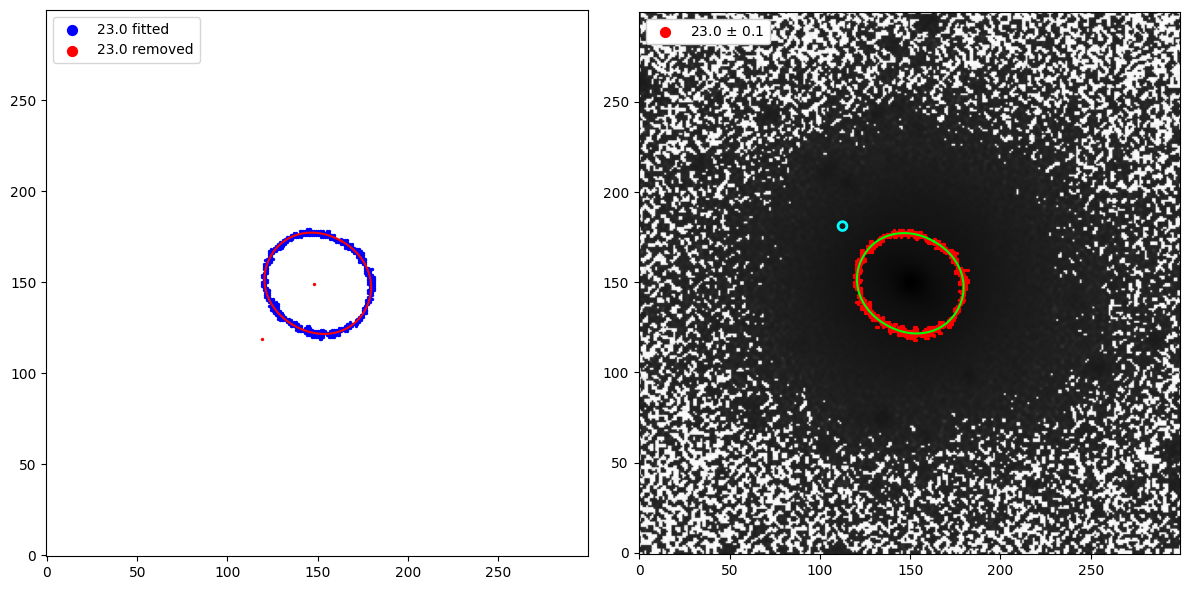

In [29]:
iso, band = 23, 'g'
gd.contour_fit(iso, mask=[], band=band)
gd.plot_fit([iso], band=band, width=0.1, zoom=False)

In [30]:
gd.main_run()

r-23.0
r-22.0
r-21.0
r-20.0
r-19.0


In [37]:
importlib.reload(glp)
bd = glp.BDdecomp(sn_name, gd)

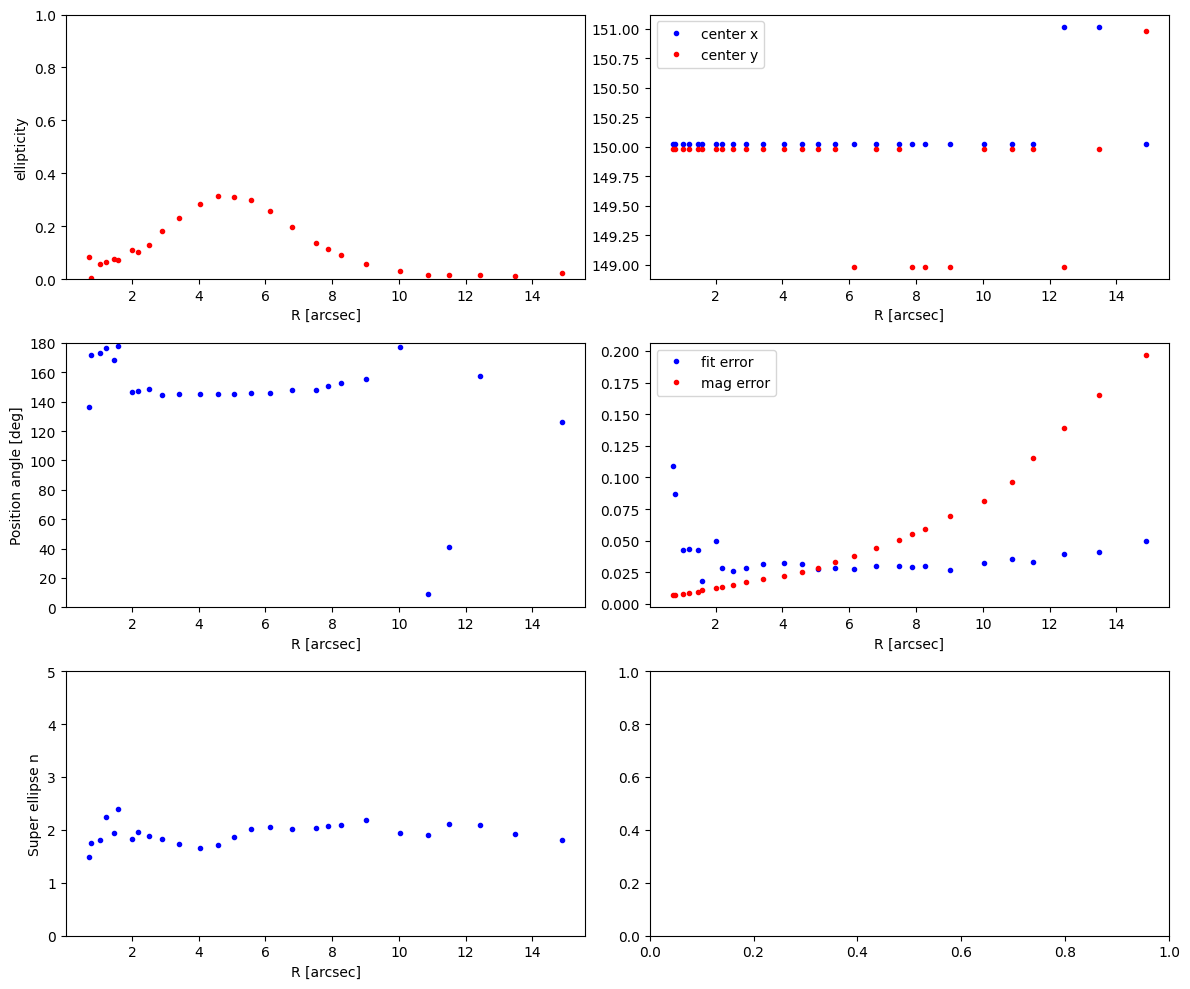

In [38]:
iso_out = bd.plot_iso(band='g')

In [39]:
bd.main_BD(spokes=12, mode=0)

One componenet, BIC: -2515.88, RSS: 12.45, fitted parameters: 7
Two componenet, BIC: -3153.47, RSS: 4.38, fitted parameters: 13


Bulge: $\mu(R) = \mu_e + \frac{2.5 b_n}{\ln 10} \left[(R/R_e)^{1/n} - 1\right]$, Free parameters: $\mu_e, R_e, n$

Disk: $\mu(R) = \mu_0 + \frac{2.5}{\ln 10} (R/h)$, Free parameters: $\mu_0, h$

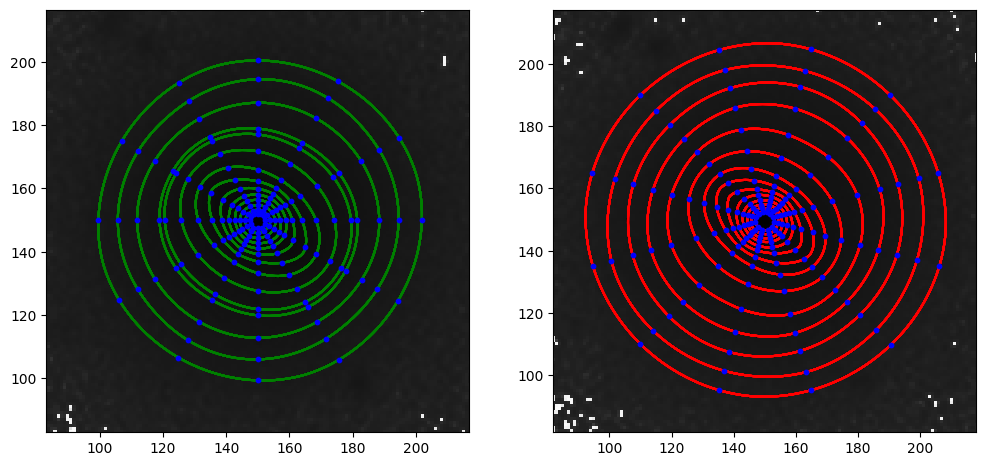

In [40]:
fig, ax = bd.plot_gal_iso(spokes=12)

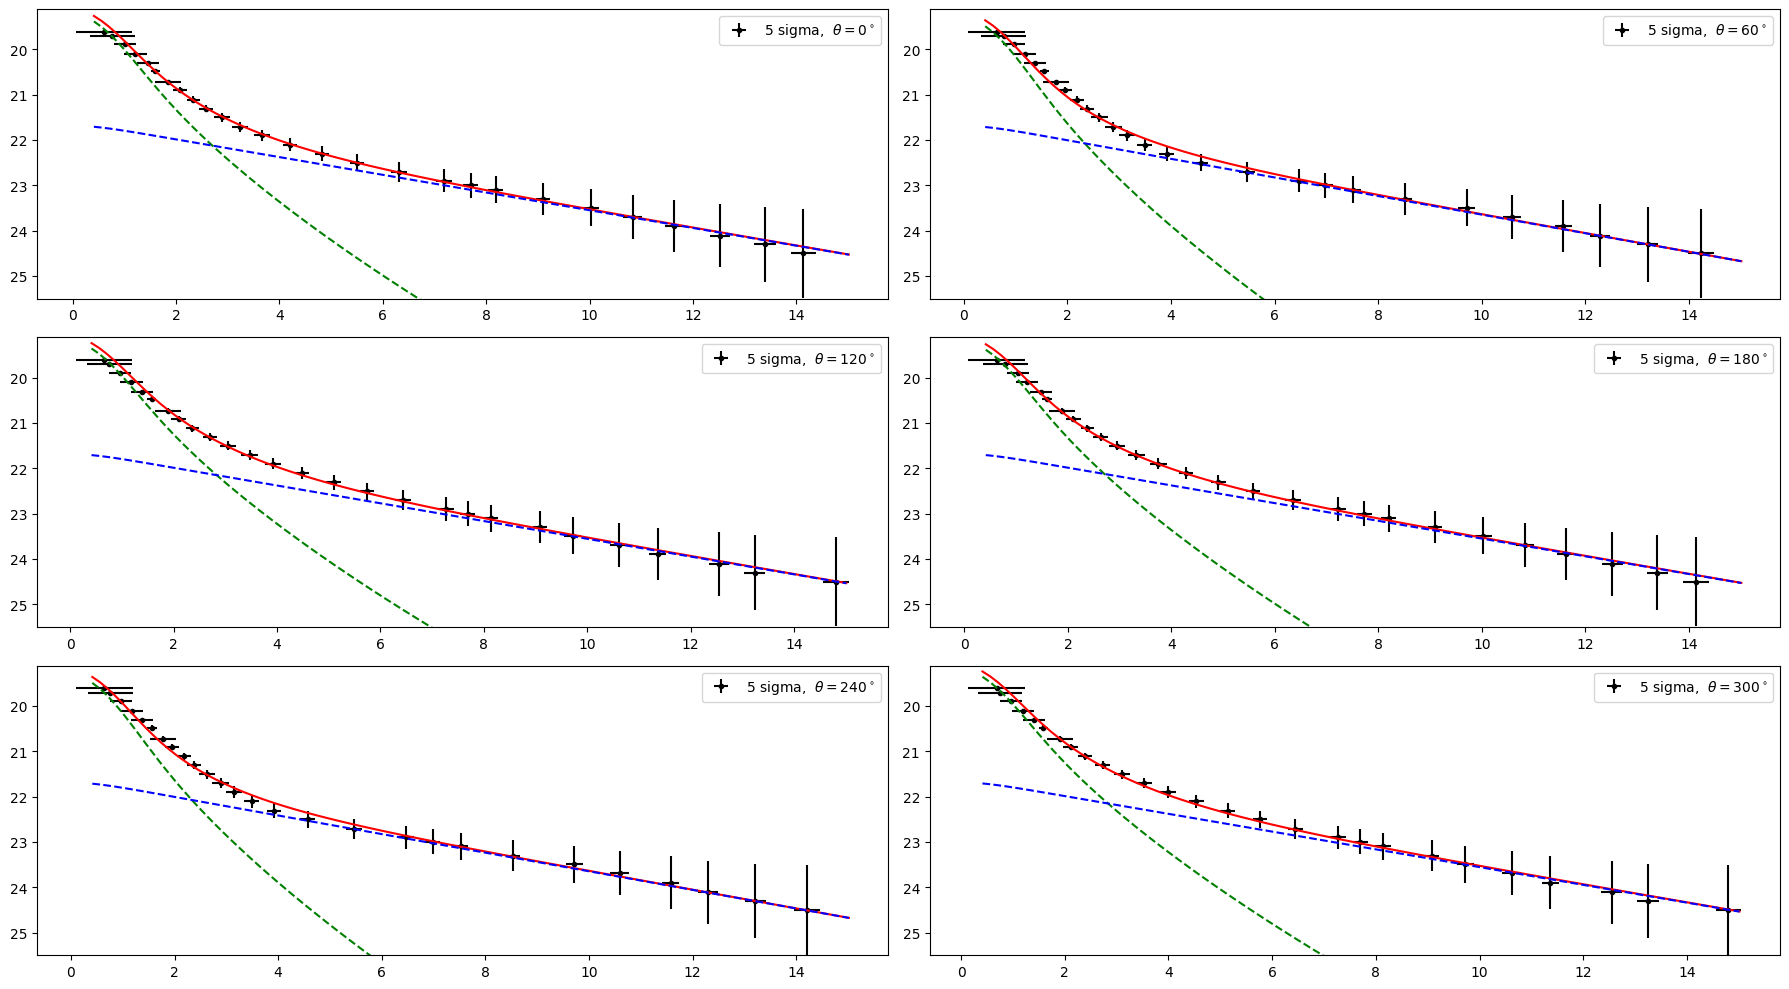

In [48]:
bd.plot_spokes(band='g', sigma=5, n_model=2)

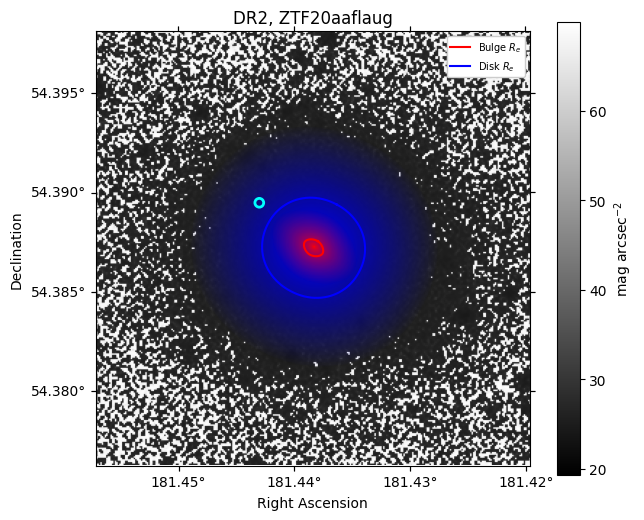

In [44]:
bd.plot_SB_profile(band='g', n_model=2)

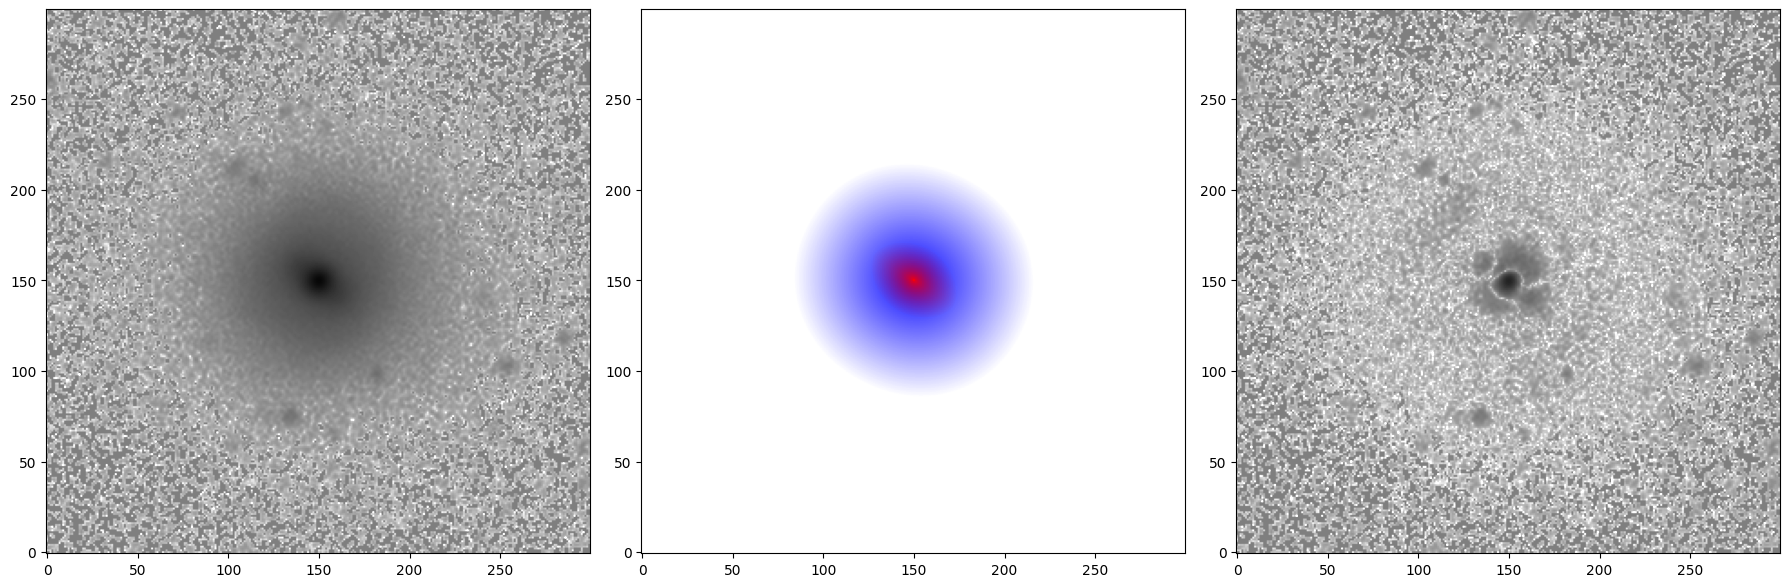

In [45]:
bd.plot_SB_profile(band='g', subtarct=True, n_model=2)

In [46]:
def psf_num(x, ue, re, n):
    r_r = np.linspace(-50, 50, 10000)
    psf_conv = -2.5*np.log10(10**(-0.4*ue)*convolve_fft(10**(-0.4*bd.bulge(r_r, 0, re, n)), bd.psf(r_r))) 
    return interp1d(r_r, psf_conv)(x)

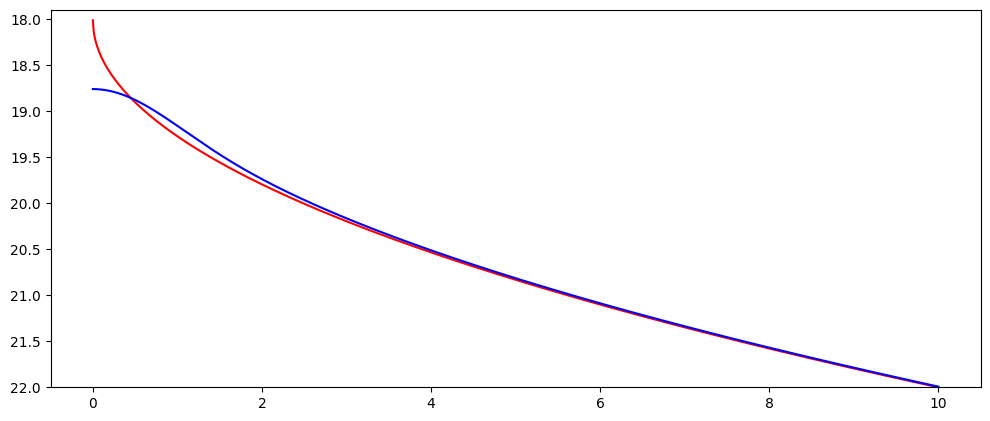

In [47]:
r_r = np.linspace(0, 10, 1000)
conv1 = bd.one_component(r_r, 22, 10, 2)
res_num = psf_num(r_r, 22, 10, 2)
fig, ax = plt.subplots(figsize=(12,5), dpi=100)
ax.plot(r_r, bd.bulge(r_r, 22, 10, 2), 'r-')
# ax.plot(r_r, conv1, 'b-')
ax.plot(r_r, res_num, 'b-')
ax.set_ylim(17.9, 22)
ax.invert_yaxis()

In [ ]:
def linear(x, a, b):
    return a*x+b

def stabilize(phi, theta, center0, center1, a, b, pa, n):
    vec = center1 - center0
    beta = np.arctan2(vec[1], vec[0])
    v_mag = np.sqrt(vec[0]**2 + vec[1]**2)
    r =  gd.super_ellipse(phi, a, b, pa, n)
    return v_mag * np.sin((theta - beta)) - r * np.sin((phi - theta))


a = [ai1, ai]
b = [bi1, bi]
pa = [pai1, pai]
n = [ni1, ni]

theta = np.deg2rad(30)
centers = np.array([[xci1,yci1], [xci+1.5, yci]])
phi = fsolve(stabilize, theta, args=(theta, centers[0], centers[1], a[1], b[1], pa[1], n[1]))
print(theta, phi)

0.5235987755982988 [0.61424498]


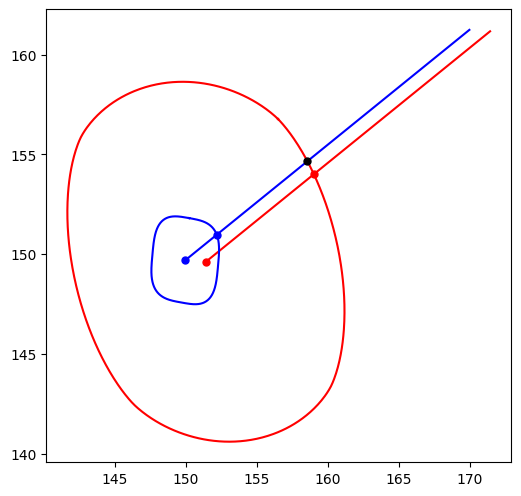

In [ ]:

colors = ['blue', 'red', 'lime', 'orange', 'purple', 'cyan']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(2):
    gd.patch_super_ellipse(pars=(a[i], b[i], pa[i], n[i]), center=centers[i], ax=ax, color=colors[i])
    ax.plot(centers[i][0], centers[i][1], 'k.', zorder=10, ms=10, c=colors[i])
    xi, yi = gd.super_ellipse(theta, a[i], b[i], pa[i], n[i], polar=False)
    ax.plot(xi+centers[i][0], yi+centers[i][1], 'k.', zorder=10, ms=10, color=colors[i])

    lx = np.linspace(centers[i][0], centers[i][0]+20)
    ax.plot(lx, linear(lx, yi/xi, -centers[i][0]*np.tan(theta) +centers[i][1]), 'k-', color=colors[i])


x_c, y_c = gd.super_ellipse(phi, a[1], b[1], pa[1], n[1], polar=False)
ax.plot(x_c+centers[i][0], y_c+centers[i][1], 'k.', zorder=10, ms=10)
# ax.set_ylim([-6, 8])
# ax.set_xlim([-12, 16])